# Task 4 Time Series Analysis
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to extract the time series


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv("../dataset/cleaned_joined_tweets.csv", index_col = 0) 
del df['lang']
del df['text']
del df['created_at_user']
del df['statuses_count']
del df['id'] #of the tweet

In [3]:
df.created_at = pd.to_datetime(df.created_at, errors='ignore').astype('datetime64[D]')
df.sort_values(by=['user_id', 'created_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4722646 entries, 4499433 to 4080317
Data columns (total 9 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
 8   bot             bool          
dtypes: bool(1), datetime64[ns](1), int64(7)
memory usage: 328.8 MB


Get only the tweets in 2019:

In [4]:
min_date = np.datetime64('2019-01-01 00:00:00')
max_date = np.datetime64('2019-12-31 23:59:59')

df_2019 = df[(df.created_at > min_date) & (df.created_at < max_date)].copy()

For each user we define a series of 365 values initialized at -1, so we define a dataframe of Number_of_users * 365

In [5]:
df_2019.head()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,bot
3343007,722623,1,0,0,0,0,2,2019-01-03,False
3343357,722623,0,0,2,0,0,0,2019-01-03,False
3343475,722623,0,0,0,0,0,0,2019-01-03,False
3343674,722623,0,0,0,0,0,0,2019-01-03,False
3344173,722623,3,0,0,0,0,1,2019-01-03,False


## Extract timeseries

### Use pivoting

In [6]:
user_2019_bot = df_2019[['user_id', 'bot']].copy()
user_2019_bot.drop_duplicates(inplace=True)
user_2019_bot.set_index('user_id', inplace=True)

In [7]:
user_2019 = df_2019.groupby(['user_id', 'created_at']).sum()

Is possible to perform the following operation, sicne in the data cleaning we filled the NaN values.

In [8]:
user_2019['success_score'] = (user_2019.retweet_count + user_2019.reply_count + user_2019.favorite_count) / (user_2019.num_hashtags + user_2019.num_urls + user_2019.num_mentions + 0.1)

Deleting the columns used for the calculation

In [9]:
del user_2019['retweet_count']
del user_2019['reply_count']
del user_2019['favorite_count']
del user_2019['num_hashtags']
del user_2019['num_urls']
del user_2019['num_mentions']

In [10]:
user_2019 = user_2019.pivot_table('success_score','created_at','user_id')
user_2019.rename_axis(columns=None, inplace=True)
user_2019.reset_index(drop=False, inplace=True)

In [11]:
dates = pd.Series(pd.date_range('01-01-2019','31-12-2019')).rename('created_at')

user_2019 = user_2019.merge(dates, how='outer', on='created_at')
user_2019.fillna(-1, inplace=True)
user_2019.set_index('created_at', inplace=True)
user_2019.sort_index(inplace=True)

In [12]:
user_2019.head()

,722623,755746,5812422,8657052,9272142,12287842,13126372,14290542,14391111,14558848,...,2469738596,2492782375,2497379616,2505222079,2528822924,2596494170,2599346388,2615998837,2619891104,2680793168
created_at,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-1.000000,-1.0,-1.00000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-02,-1.000000,-1.0,-1.00000,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-03,1.549296,0.0,0.10989,-1.0,-1.0,-1.000000,-1.000000,107.024030,0.243902,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-04,1626.393443,0.0,4.83871,-1.0,-1.0,99.503546,0.392157,39.321267,0.476190,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-05,1.818182,0.0,0.00000,-1.0,-1.0,0.000000,0.000000,415.352113,0.952381,20.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [13]:
user_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2019-01-01 to 2019-12-31
Columns: 1221 entries, 722623 to 2680793168
dtypes: float64(1221)
memory usage: 3.4 MB


In [14]:
user_2019.to_csv('../dataset/time_series.csv')

## Preprocessing

### Detect and Remove trends

In [15]:
# Augmented Dickey-Fuller test
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
non_stationary_idx_list = []

for col in user_2019.columns:
    adf = adfuller(user_2019[col])
    pvalue = adf[1]
    if pvalue > 0.05:
        non_stationary_idx_list.append(col)

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [16]:
len(non_stationary_idx_list)

325

In [17]:
# Augmented Dickey-Fuller test of example of non sationary timeseries found before
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
adf = adfuller(user_2019[non_stationary_idx_list[4]])
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -1.6827624080778236
p-value: 0.4400149689970857
Critical values:
1%: -3.4492815848836296
5%: -2.8698813715275406
10%: -2.5712138845950587


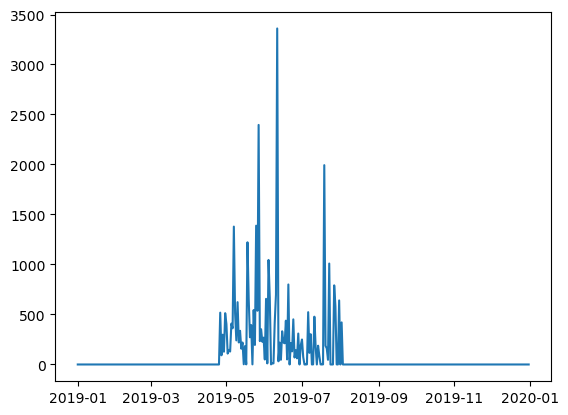

In [18]:
plt.plot(user_2019[non_stationary_idx_list[4]])
plt.show()

Trend removal

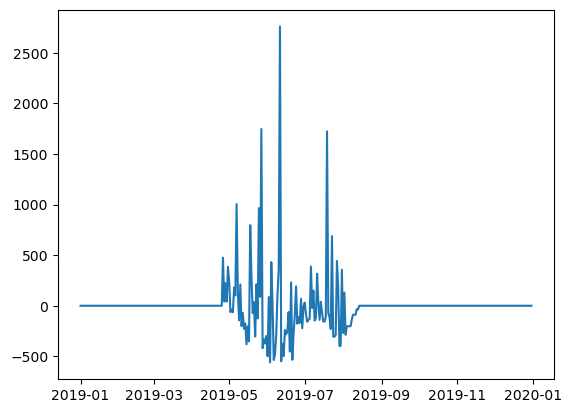

In [19]:
ts_example = user_2019[non_stationary_idx_list[4]]

ts_shift = ts_example - ts_example.rolling(window=12, min_periods=1).mean()
plt.plot(ts_shift)
plt.show()

In [20]:
# Augmented Dickey-Fuller test of example of timeseries after trend removal
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
adf = adfuller(ts_shift)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -4.547375268160341
p-value: 0.0001613089969226971
Critical values:
1%: -3.4492815848836296
5%: -2.8698813715275406
10%: -2.5712138845950587


Remove trends for all timeseries with trend

In [21]:
user_2019_detrend = user_2019.copy()

for col in non_stationary_idx_list:
    user_2019_detrend[col] = user_2019_detrend[col] - user_2019_detrend[col].rolling(window=12, min_periods=1).mean()

In [22]:
user_2019_detrend.to_csv('../dataset/time_series_trendless.csv')

### Noise detection

(365,)


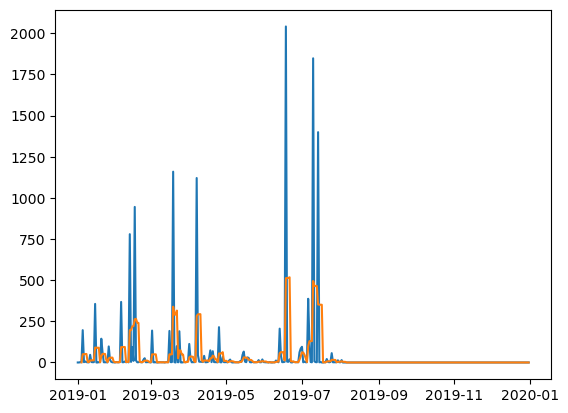

In [23]:
ts_example = user_2019.iloc[:, 29]

print(np.shape(ts_example))

plt.plot(ts_example)
plt.plot(ts_example.rolling(window=4).mean())
plt.show()

To find the best sliding window for the noise we used the mean of the sums of absolute differences between the original timeseries and the smoothed one, then me resorted to the elbow method to choose the best window that 'doesn't smooth too much' the original timeseries.

In [24]:
noise_windows = np.array(range(1,21))

mean_sad_dict = dict()

for window_size in tqdm(noise_windows):
    sum_abs_diff_users = list()

    for user_id in user_2019_detrend.columns:
        sum_abs_diff_single_per_user = np.sum(np.abs(user_2019_detrend[user_id].rolling(window=window_size, center = True, min_periods = 1).mean() - user_2019_detrend[user_id]))
        sum_abs_diff_users.append(sum_abs_diff_single_per_user)
    
    mean_sad_dict[window_size] = np.average(sum_abs_diff_users)

100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


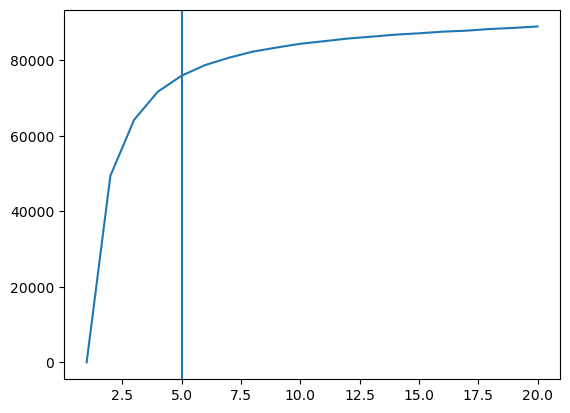

In [25]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(5)
plt.show()

The result of this analisys is window size = 5

In [26]:
window_size = 5

In [27]:
def denoiser(df, window_size):
    denoised_df = df.apply(lambda ts : ts.rolling(window=window_size, center = True, min_periods = 1).mean())

    return denoised_df

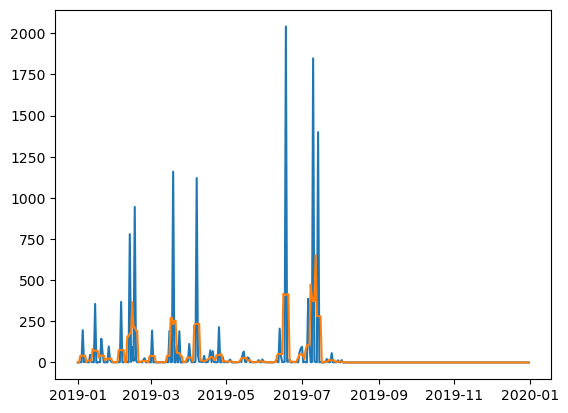

In [28]:
denoised_user_2019 = denoiser(user_2019_detrend,window_size=window_size)
user_id = 29

plt.plot(user_2019.iloc[:, user_id])
plt.plot(denoised_user_2019.iloc[:, user_id])
plt.show()

### Scaler

#### Mean Variance

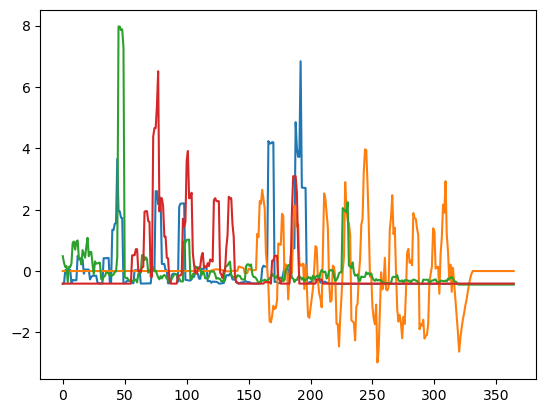

In [29]:
#scaler mean variance
user_2019_std = pd.DataFrame(columns=denoised_user_2019.columns)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  
for col in denoised_user_2019.columns:
    user_2019_std[col] = scaler.fit_transform(denoised_user_2019[col].values.reshape(1, -1)).flatten()

ts_example_1 = user_2019_std.iloc[:, 29]
ts_example_2 = user_2019_std.iloc[:, 567]
ts_example_3 = user_2019_std.iloc[:, 1000]
ts_example_4 = user_2019_std.iloc[:, 867]
plt.plot(ts_example_1)
plt.plot(ts_example_2)
plt.plot(ts_example_3)
plt.plot(ts_example_4)
plt.show()

## Clustering timeseries

### Shape-Based clustering
#### K-Means

In [36]:
from tslearn.clustering import TimeSeriesKMeans
import random
import warnings

In [30]:
user_list = user_2019_detrend.columns.to_list()

In [31]:
def print_clusters(y, K, model):
    print("k = ", K, "| Clusters =", np.unique(y,return_counts=True)[1], "| Inertia =", model.inertia_)

In [29]:
with warnings.catch_warnings(record=True):
    data_array = np.transpose(user_2019_std.values)
    inertia_dict = dict()

    for mtype in (['euclidean']):
        inertia_dict[mtype] = list()
        print("Clusters sizes for each K with", mtype, "metric")

        for n_clusters in range(2, 11):
            model = TimeSeriesKMeans(n_clusters=n_clusters, metric=mtype, max_iter=10)
            model.fit(data_array)
            y = model.predict(data_array)
            print_clusters(y, n_clusters, model)
            inertia_dict[mtype].append(model.inertia_)
        print("\n")

NameError: name 'user_2019_std' is not defined

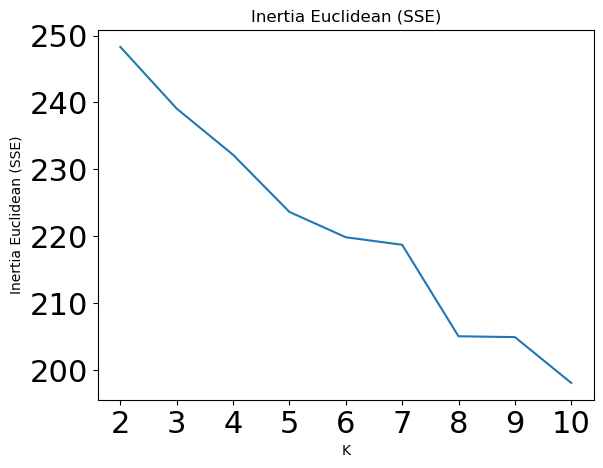

In [39]:
plt.plot(range(2, len(inertia_dict['euclidean']) + 2), inertia_dict['euclidean'])
plt.ylabel('Inertia Euclidean (SSE)')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(2,11))
plt.title('Inertia Euclidean (SSE)')
#plt.yscale('log')
plt.show()

In [ ]:
plt.plot(range(2, len(inertia_dict['dtw']) + 2), inertia_dict['dtw'])
plt.ylabel('Inertia DTW')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(2,11))
plt.title('Inertia DTW')
#plt.yscale('log')
plt.show()

In [ ]:
'''num_samples_per_cluster = 1
for c in range(n_clusters):
    cluster_index = [i for i, x in enumerate(y) if x == c] 
    random_indexes = np.random.choice(cluster_index, size=num_samples_per_cluster, replace=False)
    user_cluster_sample = user_2019_std.iloc[:,random_indexes]
    
    for id in user_cluster_sample.columns:
        plt.plot(user_cluster_sample[id])

    plt.show()
    '''

### Feature based clustering

In [41]:
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [42]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [43]:
data_array = np.transpose(user_2019_std.values)

data_array_features = [list(calculate_features(x).values())[:-2] for x in data_array]

#### K-Means

In [44]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(data_array_features)

In [45]:
def KMeansFunction (X, n_clusters_list, n_init_value, max_iter_value=300):
    kmeans_list = list()

    for numCluster in tqdm(n_clusters_list):
        # Define and fit K-Means
        kmeans = KMeans(n_clusters=numCluster, n_init=n_init_value, max_iter=max_iter_value)
        kmeans.fit(X)
        kmeans_list.append(kmeans)
    
    return kmeans_list

In [46]:
# Params for kmeans
clusters_list = [x for x in range(2, 20)]
init_value = 10
iter_value = 300

# Get list of kmeans with from the list of possible k
kmeans_list = KMeansFunction (X_minmax, clusters_list, init_value, iter_value)

# Calculate SSE and Silhouette for each kmeans
sse_list = []
silhouette_list = []
for i, kmeans in enumerate(kmeans_list):
    sse_list.append(kmeans.inertia_)
    print_clusters(kmeans.labels_, clusters_list[i], kmeans)
    #print('K:', clusters_list[i], ' - SSE:', kmeans.inertia_, '- SILHOUETTE:')

100%|██████████| 18/18 [00:03<00:00,  4.65it/s]

k =  2 | Clusters = [3309 3478] | Inertia = 760.611046876473
k =  3 | Clusters = [3177 3139  471] | Inertia = 515.7051747556267
k =  4 | Clusters = [ 701  431 2541 3114] | Inertia = 382.1408834976077
k =  5 | Clusters = [ 695 1951 1839  361 1941] | Inertia = 304.50672519169296
k =  6 | Clusters = [1858 1845  286  694 1611  493] | Inertia = 260.60660210042454
k =  7 | Clusters = [1193 1273  437 1278  691 1632  283] | Inertia = 231.66012818068612
k =  8 | Clusters = [1192  918  881  690  283 1149 1233  441] | Inertia = 213.81733816274473
k =  9 | Clusters = [ 967  281  670  893 1222  411  861 1104  378] | Inertia = 195.91196367564018
k =  10 | Clusters = [ 883 1213  179  652  140 1117  968  864  399  372] | Inertia = 181.4931754778939
k =  11 | Clusters = [1178  885  885  183 1095  652  130  866  372  110  431] | Inertia = 168.01661358465304
k =  12 | Clusters = [ 133 1058  517  135  171  652  824  809  908  371  428  781] | Inertia = 159.5173924970638
k =  13 | Clusters = [371 811 815 1

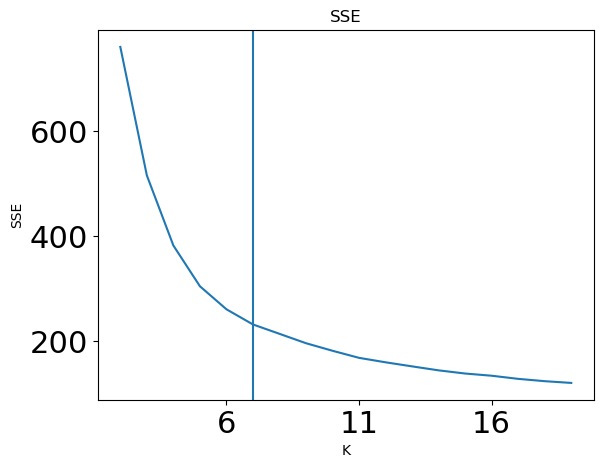

In [47]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE')
plt.xlabel('K')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(clusters_list[4::5])
plt.title('SSE')
plt.axvline(7)
#plt.yscale('log')
plt.show()

In this case we choose K = 7 as we can deduct from the knee method. We can also see during the execution that from K=>7, there are 3 big clusters.

Plotta time series per ogni cluster

#### Hierachical

In [48]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fclusterdata

In [49]:
scaler = StandardScaler()
X_std = scaler.fit_transform(data_array_features)

In [50]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(data_array_features)

##### With minmax normalization


In [51]:
config_hierarchical_minamx = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 0.2, n_clusters: 5

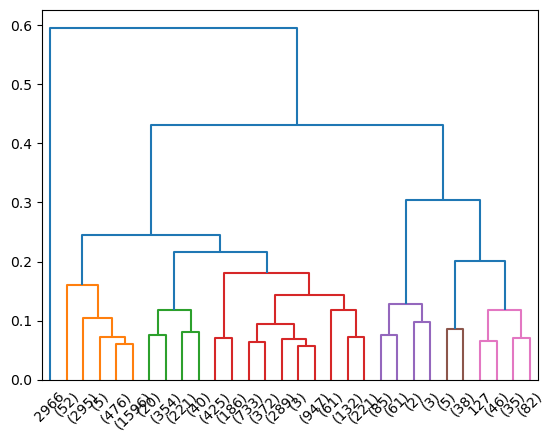

In [52]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=0.35, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.35, 'cosine', 'complete'))

method: ward, threshold:0.8, n_clusters: 2

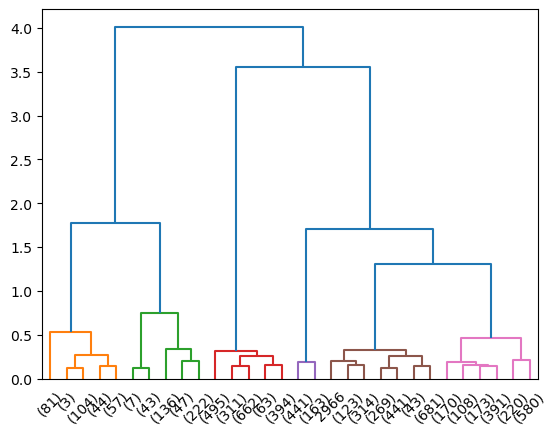

In [53]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=0.8, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.8, 'cosine', 'ward'))

method: average, threshold: 0.2, n_clusters: 5

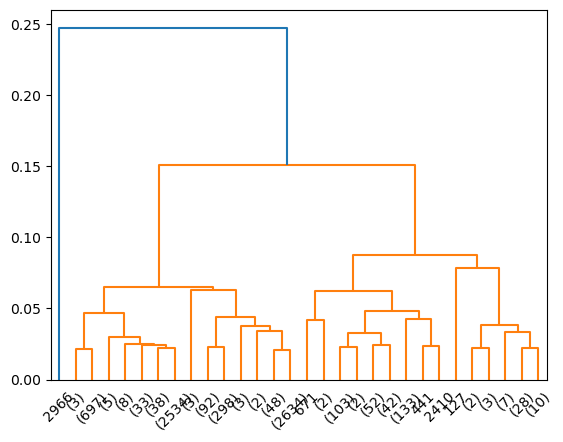

In [54]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.1, 'cosine', 'average'))

method: centroid, threshold: 0.2, n_clusters: 5

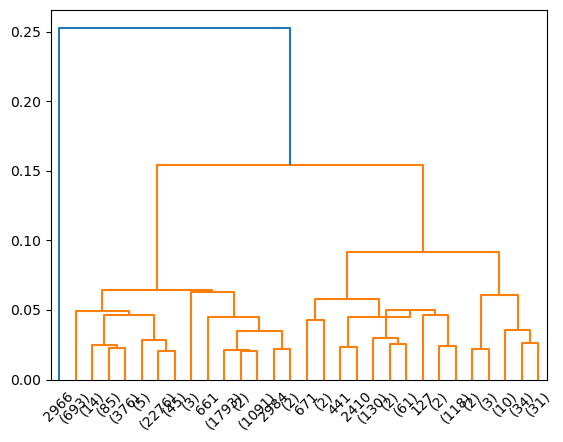

In [55]:
# Generate dendrogram
data_dist = pdist(X_minmax, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.1, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_minamx.append((0.1, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [56]:
cluster_list_minmax = []
for treshold, metric_minmax, method_minmax in config_hierarchical_minamx:
    cluster = fclusterdata(X=X_minmax,
     t=treshold , criterion='distance', metric=metric_minmax, method=method_minmax)
     
    cluster_list_minmax.append(cluster)

Calculate Silhouette for each clustering.

In [57]:
for i, clustering in enumerate(cluster_list_minmax):
    treshold, metric, method = config_hierarchical_minamx[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_minmax, clustering)
    except:
        silhouette = np.nan
    print("MINMAX - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

MINMAX - dist: cosine , method: complete , SILHOUTTE: 0.1746834030084786 , n_clusters: 7
Clusters Size: [2424, 635, 3369, 151, 43, 164, 1]


MINMAX - dist: cosine , method: ward , SILHOUTTE: 0.3672373491511077 , n_clusters: 6
Clusters Size: [289, 455, 1925, 604, 1872, 1642]


MINMAX - dist: cosine , method: average , SILHOUTTE: 0.5322326727997804 , n_clusters: 2
Clusters Size: [6786, 1]


MINMAX - dist: cosine , method: centroid , SILHOUTTE: 0.5322326727997804 , n_clusters: 2
Clusters Size: [6786, 1]




##### With mean-std normalization


In [58]:
config_hierarchical_std = []

Show generated dendrogram for hierarchical clustering with selected params and the best threshold for that dendrogram.

method: complete, threshold: 1, n_clusters: 7

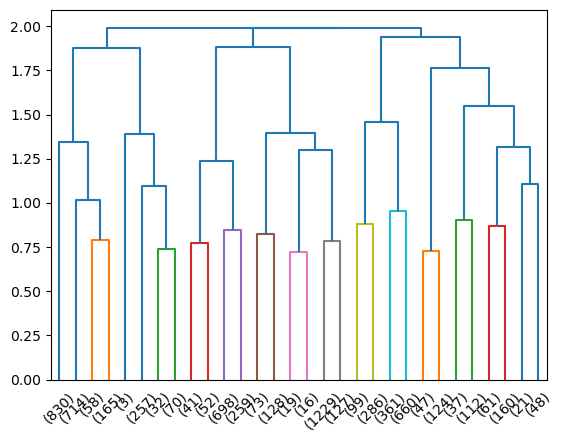

In [59]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='complete', metric='cosine')
res = dendrogram(data_link, color_threshold=1.65, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((1.65, 'cosine', 'complete'))

method: ward, threshold: 20, n_clusters: 3

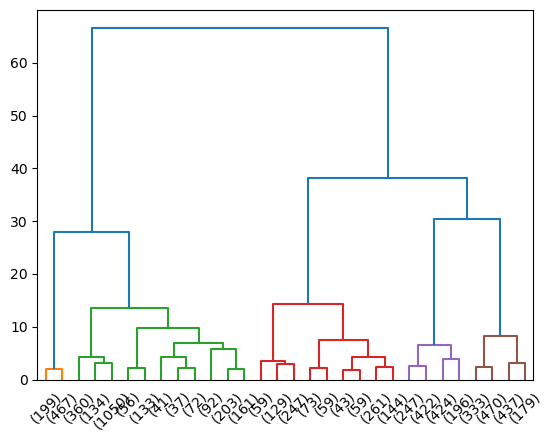

In [60]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='ward', metric='cosine')
res = dendrogram(data_link, color_threshold=20, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((20, 'cosine', 'ward'))

method: average, threshold: 0.6, n_clusters: 6

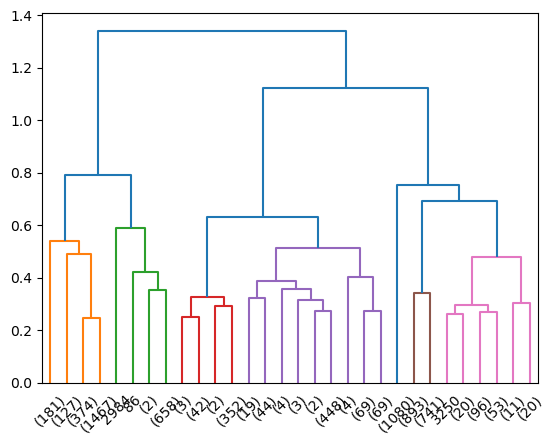

In [61]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='average', metric='cosine')
res = dendrogram(data_link, color_threshold=0.6, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.6, 'cosine', 'average'))

method: centroid, threshold: 0.6, n_clusters: 5

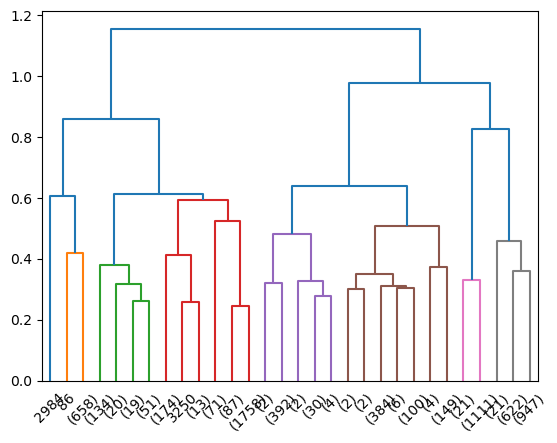

In [62]:
# Generate dendrogram
data_dist = pdist(X_std, metric='cosine')
data_link = linkage(data_dist, method='centroid', metric='cosine')
res = dendrogram(data_link, color_threshold=0.7, truncate_mode='lastp')
plt.show()
# Append params for this dendrogram to list
config_hierarchical_std.append((0.7, 'cosine', 'centroid'))

Fit clusterings with params found by exploring dendrograms

In [63]:
cluster_list_std = []
for treshold, metric_std, method_std in config_hierarchical_std:
    cluster = fclusterdata(X=X_std,
     t=treshold , criterion='distance', metric=metric_std, method=method_std)
     
    cluster_list_std.append(cluster)

Calculate Silhouette for each clustering.

In [64]:
for i, clustering in enumerate(cluster_list_std):
    treshold, metric, method = config_hierarchical_std[i]
    n_clusters = len(np.unique(clustering))
    occ_list = []
    for k in range(1, n_clusters+1):
        occ_list.append(np.count_nonzero(clustering == k))

    try: # Exception in case of num_clusters=1
        silhouette = silhouette_score(X_std, clustering)
    except:
        silhouette = np.nan
    print("STD - dist:", metric, ", method:", method, ", SILHOUTTE:", silhouette, ", n_clusters:", n_clusters)
    print('Clusters Size:', occ_list)
    print('\n')

STD - dist: cosine , method: complete , SILHOUTTE: 0.18680093170997833 , n_clusters: 18
Clusters Size: [830, 714, 223, 3, 257, 102, 93, 957, 201, 35, 1356, 385, 1021, 171, 149, 221, 21, 48]


STD - dist: cosine , method: ward , SILHOUTTE: 0.3951190192772984 , n_clusters: 5
Clusters Size: [666, 2339, 1074, 1289, 1419]


STD - dist: cosine , method: average , SILHOUTTE: 0.23764804683501092 , n_clusters: 7
Clusters Size: [2149, 662, 399, 662, 1080, 1634, 201]


STD - dist: cosine , method: centroid , SILHOUTTE: 0.2424931368053059 , n_clusters: 8
Clusters Size: [659, 1, 224, 2104, 430, 647, 1132, 1590]




### Compression based clustering

In [69]:
from tslearn.piecewise import PiecewiseAggregateApproximation

In [70]:
data_array = np.transpose(user_2019_std.values)

In [108]:
n_paa_segments = 27

paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(data_array)

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


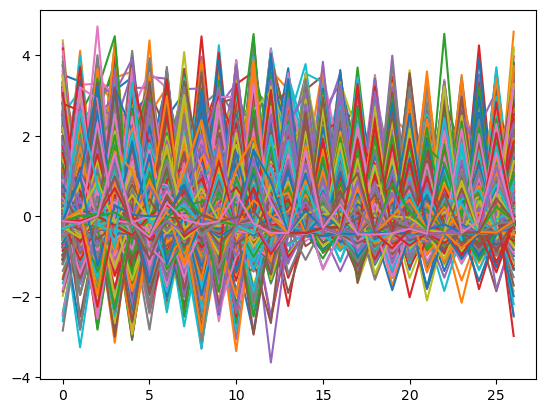

In [109]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [110]:
km = TimeSeriesKMeans(n_clusters=8, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_paa)

TimeSeriesKMeans(max_iter=5, n_clusters=8, random_state=0)

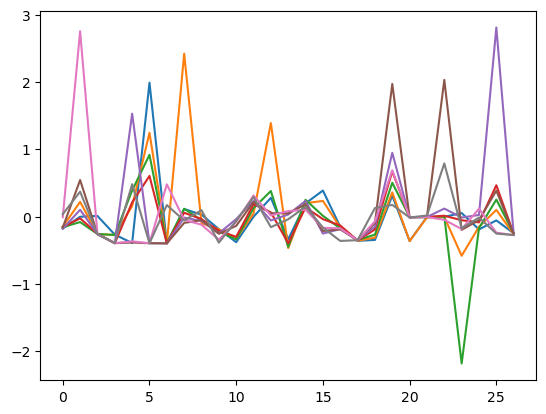

In [111]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 8))
plt.show()

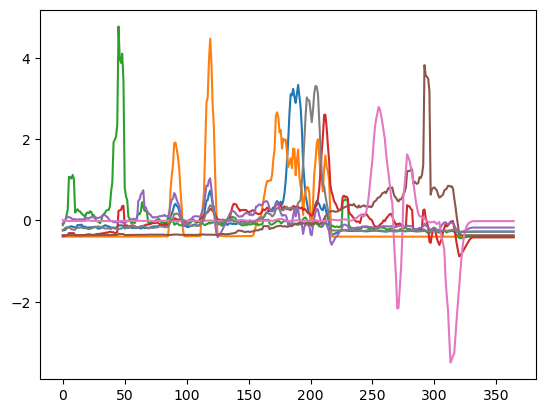

In [112]:
for i in range(8):
    plt.plot(np.mean(data_array[np.where(km.labels_ == i)[0]], axis=0))
plt.show()

## Shapelets

In [30]:
from tensorflow.keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax

In [31]:
user_2019_std.head()

,722623,755746,5812422,8657052,9272142,12287842,13126372,14290542,14391111,14558848,...,2469738596,2492782375,2497379616,2505222079,2528822924,2596494170,2599346388,2615998837,2619891104,2680793168
0,-0.126471,-0.327108,-0.438843,-0.319265,-0.126187,-0.310099,-0.217975,-0.122835,1.440337,-0.118563,...,-0.271236,-0.159385,-0.117851,-0.156636,-0.360049,-0.193973,-0.187739,-0.171211,-0.229301,-0.119589
1,-0.061626,-0.324451,-0.429264,-0.319265,-0.126187,-0.158660,-0.215284,-0.122793,2.099263,-0.118563,...,-0.271236,-0.159385,-0.117851,-0.156636,-0.360049,-0.193973,-0.187739,-0.171211,-0.229301,-0.119589
2,-0.074532,-0.322857,-0.430297,-0.319265,-0.126187,-0.187742,-0.214276,-0.119772,2.719492,-0.118396,...,-0.271236,-0.159385,-0.117851,-0.156636,-0.360049,-0.193973,-0.187739,-0.171211,-0.229301,-0.119589
3,-0.074490,-0.319145,-0.428896,-0.319265,-0.126187,-0.103038,-0.214276,-0.118928,2.774856,-0.118396,...,-0.271236,-0.159385,-0.117851,-0.156636,-0.360049,-0.193973,-0.187739,-0.171211,-0.229301,-0.119589
4,-0.074091,-0.315957,-0.098325,-0.319265,-0.126187,-0.101832,-0.214276,-0.118805,2.822312,-0.118388,...,-0.271236,-0.159385,-0.117851,-0.156636,-0.360049,-0.193973,-0.187739,-0.171211,-0.229301,-0.119589


In [32]:
user_2019_bot.head()

,bot
user_id,
722623,False
755746,False
5812422,False
8657052,False
9272142,False


In [34]:
data_array = np.transpose(user_2019_std.values)
labels = np.transpose(user_2019_bot.values)

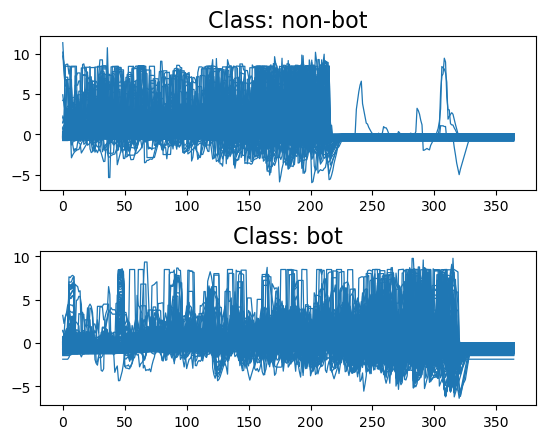

In [36]:
plt.figure()
for i, classe in enumerate(['non-bot', 'bot']):
    plt.subplot(2, 1, i + 1)
    mask = labels == i
    for x in data_array[mask[0]]:
        plt.plot(x, color='C0', linewidth=0.9)
    plt.title('Class: {}'.format(classe), fontsize=16)
    

#plt.tight_layout()
plt.subplots_adjust(hspace=0.4)

plt.show()

In [38]:
print(data_array.shape)

(1221, 365)


In [93]:
n_ts, ts_sz = data_array.shape
n_classes = 2

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.01,
                                                       r=5)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 1221
ts_sz 365
n_classes 2
shapelet_sizes {3: 5, 6: 5, 9: 5, 12: 5, 15: 5}


Drop the shapelets with size 3 because they are too small

In [94]:
shapelet_sizes.pop(3)
print('shapelet_sizes', shapelet_sizes)

shapelet_sizes {6: 5, 9: 5, 12: 5, 15: 5}


In [95]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=1)

c:\Users\giaco\anaconda3\envs\PythonGPU\lib\site-packages\tslearn\shapelets\shapelets.py:357: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  FutureWarning)


In [81]:
labels = labels.reshape(labels.shape[1])
print(labels.shape)

IndexError: tuple index out of range

In [96]:
shp_clf.fit(data_array, labels)

Train on 1221 samples
Epoch 1/200
1221/1221 [==============================] - 3s 3ms/sample - loss: 0.9069 - binary_accuracy: 0.4996 - binary_crossentropy: 0.8903
Epoch 2/200
1221/1221 [==============================] - 0s 113us/sample - loss: 0.8376 - binary_accuracy: 0.4914 - binary_crossentropy: 0.8213
Epoch 3/200
1221/1221 [==============================] - 0s 106us/sample - loss: 0.8293 - binary_accuracy: 0.5020 - binary_crossentropy: 0.8132
Epoch 4/200
1221/1221 [==============================] - 0s 106us/sample - loss: 0.8255 - binary_accuracy: 0.5061 - binary_crossentropy: 0.8097
Epoch 5/200
1221/1221 [==============================] - 0s 107us/sample - loss: 0.8219 - binary_accuracy: 0.5119 - binary_crossentropy: 0.8063
Epoch 6/200
1221/1221 [==============================] - 0s 109us/sample - loss: 0.8186 - binary_accuracy: 0.5078 - binary_crossentropy: 0.8033
Epoch 7/200
1221/1221 [==============================] - 0s 104us/sample - loss: 0.8156 - binary_accuracy: 0.5111 - 

LearningShapelets(max_iter=200, n_shapelets_per_size={6: 5, 9: 5, 12: 5, 15: 5},
                  verbose=1, weight_regularizer=0.01)

In [97]:
predicted_labels = shp_clf.predict(data_array)
print("Correct classification rate:", accuracy_score(labels, predicted_labels))
predicted_locations = shp_clf.locate(data_array)

1221/1221 [==============================] - 0s 328us/sample
Correct classification rate: 0.6904176904176904
1221/1221 [==============================] - 0s 307us/sample


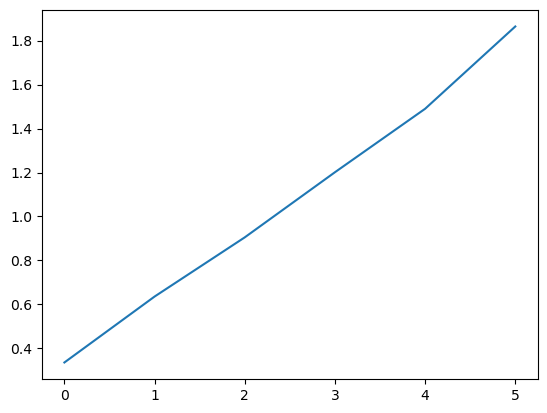

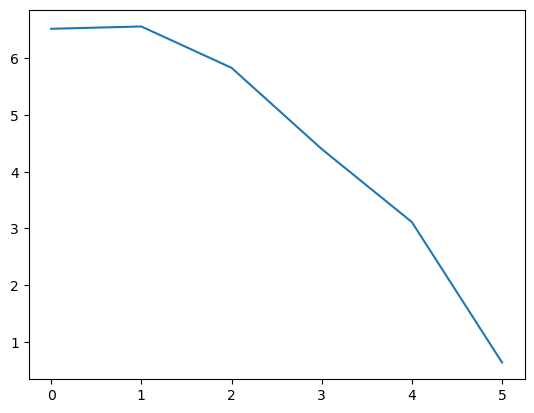

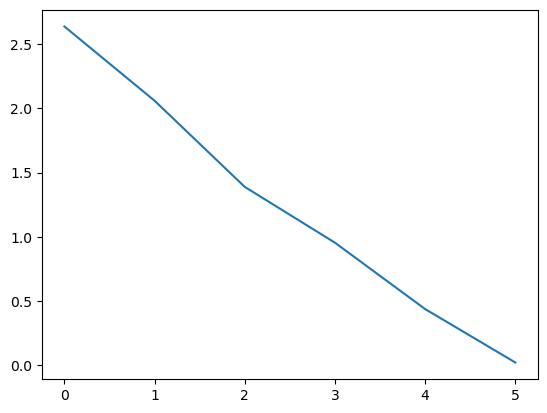

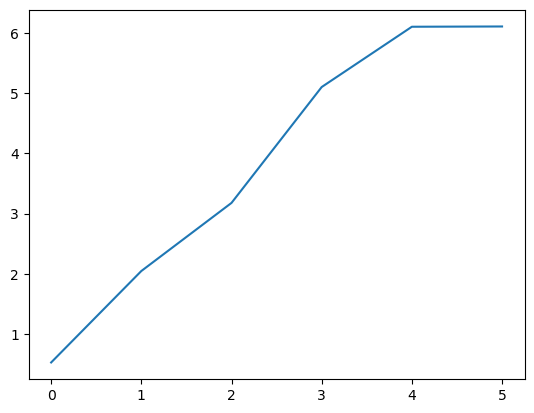

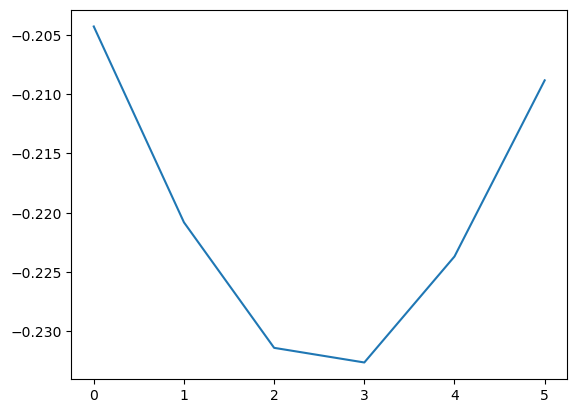

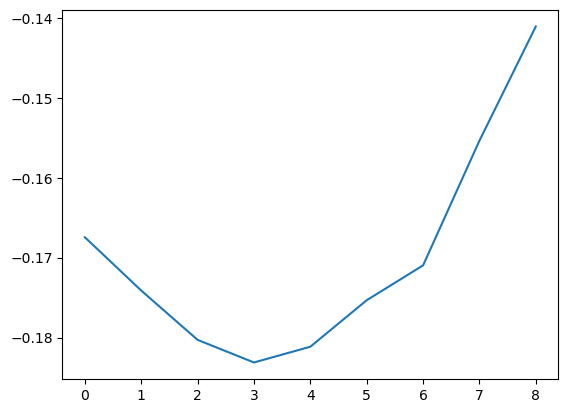

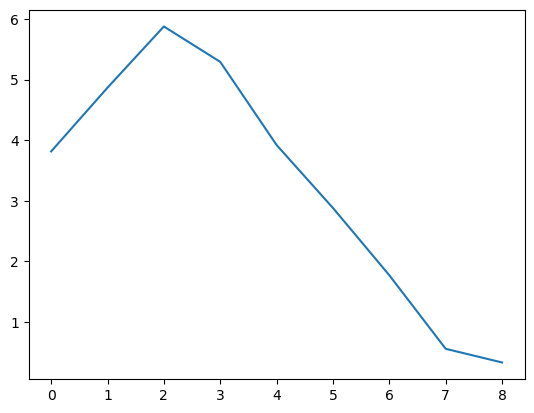

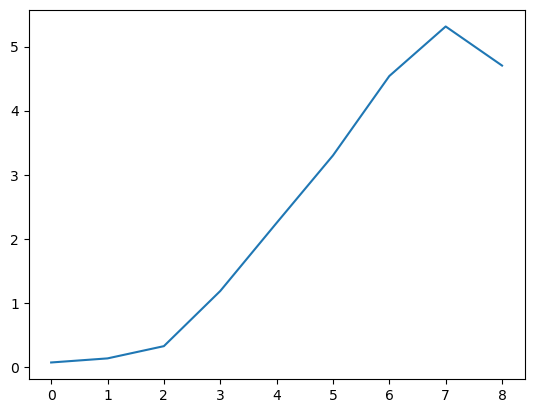

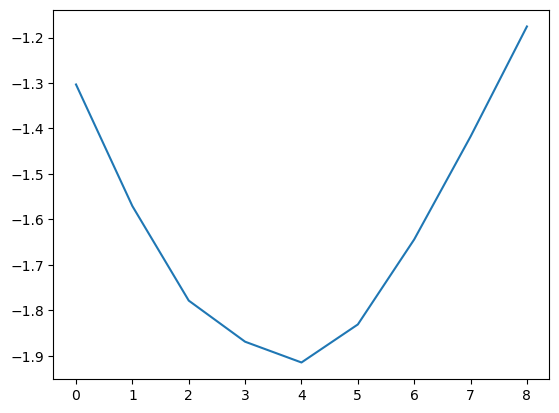

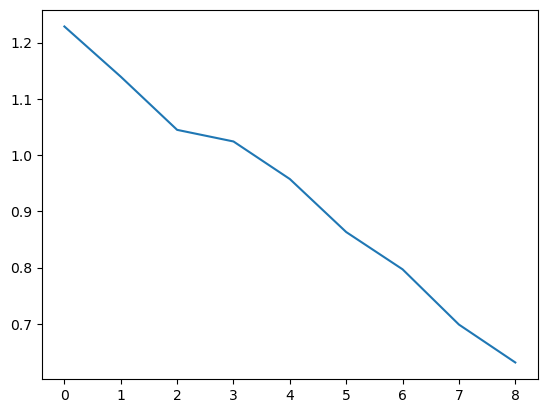

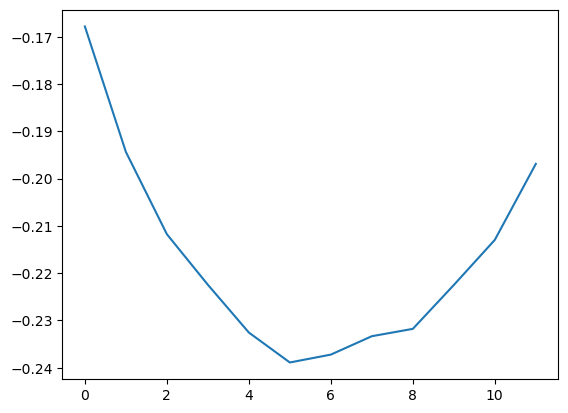

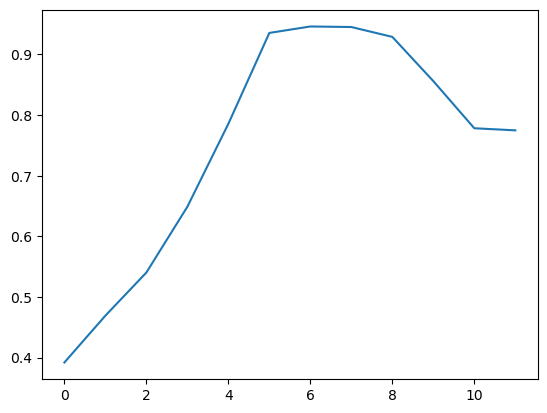

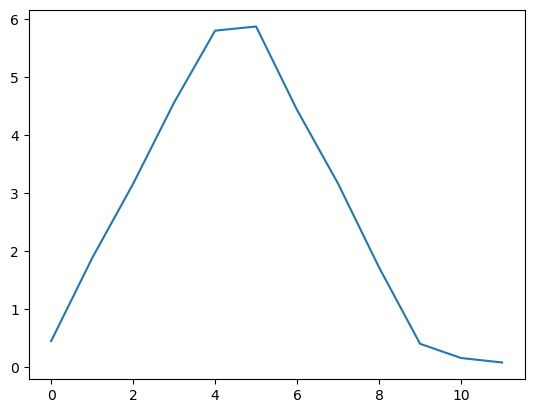

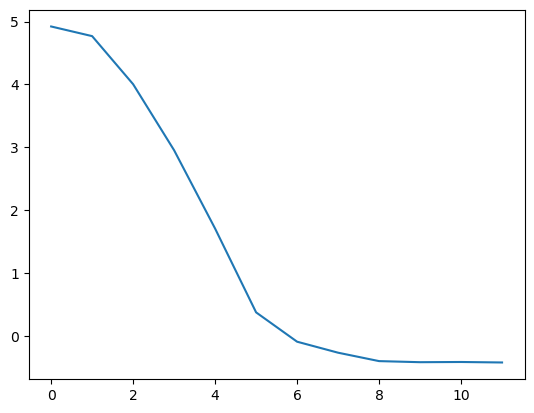

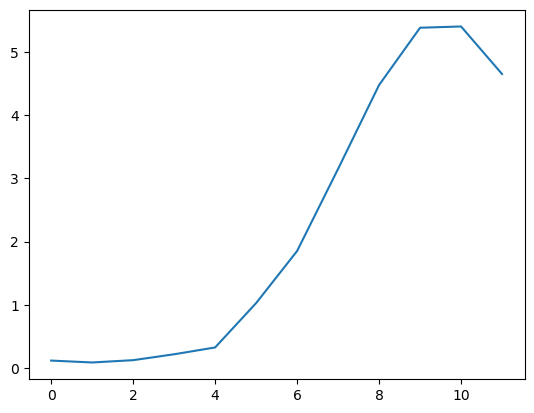

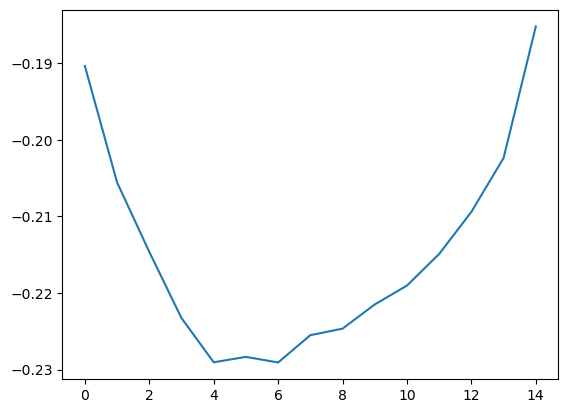

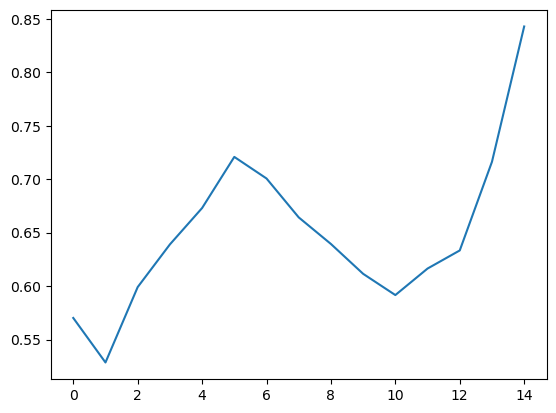

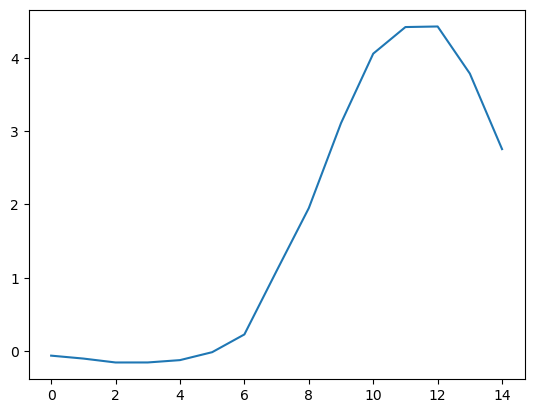

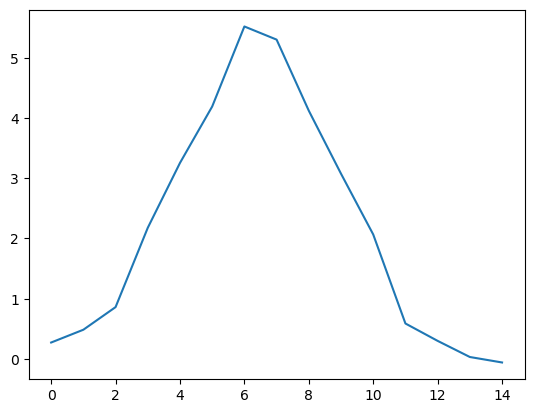

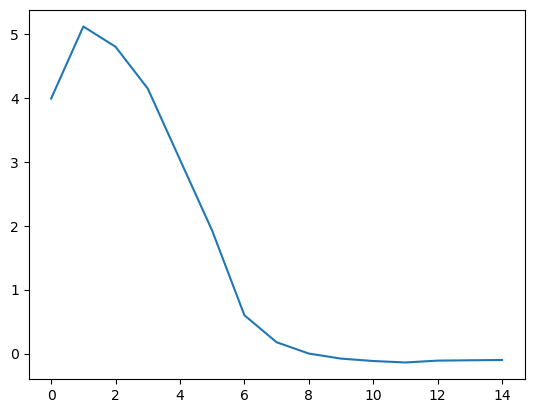

In [98]:
len(shp_clf.shapelets_)
for shp in shp_clf.shapelets_:
    plt.plot(shp)
    plt.show()

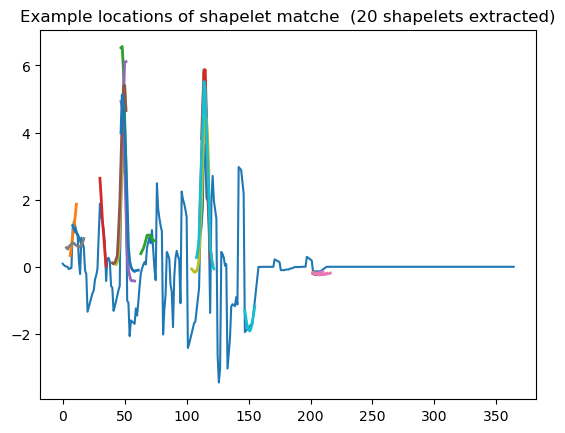

In [111]:
ts_id = 88
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matche  ({} shapelets extracted)".format(n_shapelets))

plt.plot(data_array[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
plt.show()